In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.random import randint
from multiprocessing import cpu_count
import os
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE #for feature selection
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluatin metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import gc
import pandas as pd
import numpy as np
import os
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report

## MLP

In [3]:
# Укажем путь к данным
DATA_PATH = r"/content/drive/MyDrive/home-credit-default-risk"

# Загружаем данные
app_train = pd.read_csv(os.path.join(DATA_PATH, "application_train.csv"))

# Выбираем только числовые признаки
num_features = app_train.select_dtypes(include=[np.number]).drop(columns=["TARGET", "SK_ID_CURR"])

# Заполняем пропущенные значения медианными
imputer = SimpleImputer(strategy='median')
num_features_imputed = pd.DataFrame(imputer.fit_transform(num_features), columns=num_features.columns)

# Добавляем новые признаки
num_features_imputed['CREDIT_INCOME_RATIO'] = num_features_imputed['AMT_CREDIT'] / (num_features_imputed['AMT_INCOME_TOTAL'] + 1)
num_features_imputed['ANNUITY_INCOME_RATIO'] = num_features_imputed['AMT_ANNUITY'] / (num_features_imputed['AMT_INCOME_TOTAL'] + 1)
num_features_imputed['DAYS_EMPLOYED_RATIO'] = num_features_imputed['DAYS_EMPLOYED'] / (num_features_imputed['DAYS_BIRTH'] + 1)

In [4]:
# масштабирование признаков

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(num_features_imputed), columns=num_features_imputed.columns)

In [5]:
y = app_train["TARGET"].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
import torch
from torch.utils.data import DataLoader, TensorDataset

X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

class ImprovedMLP(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1)  # ← без Sigmoid
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Преобразуем данные
X_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [10]:
pos_weight_val = len(y_train) / sum(y_train)
pos_weight = torch.tensor([pos_weight_val], dtype=torch.float32)

model = ImprovedMLP(input_dim=X_train.shape[1])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {epoch_loss:.4f}")

Epoch 1/100 | Loss: 1147.8194
Epoch 2/100 | Loss: 1124.7533
Epoch 3/100 | Loss: 1121.5709
Epoch 4/100 | Loss: 1118.9778
Epoch 5/100 | Loss: 1116.3954
Epoch 6/100 | Loss: 1115.6375
Epoch 7/100 | Loss: 1113.9509
Epoch 8/100 | Loss: 1111.9562
Epoch 9/100 | Loss: 1110.9323
Epoch 10/100 | Loss: 1109.0517
Epoch 11/100 | Loss: 1108.8983
Epoch 12/100 | Loss: 1107.3580
Epoch 13/100 | Loss: 1106.9350
Epoch 14/100 | Loss: 1104.8197
Epoch 15/100 | Loss: 1104.7915
Epoch 16/100 | Loss: 1101.6170
Epoch 17/100 | Loss: 1101.6495
Epoch 18/100 | Loss: 1102.1775
Epoch 19/100 | Loss: 1100.8318
Epoch 20/100 | Loss: 1100.1966
Epoch 21/100 | Loss: 1100.0342
Epoch 22/100 | Loss: 1098.6239
Epoch 23/100 | Loss: 1097.2341
Epoch 24/100 | Loss: 1097.4751
Epoch 25/100 | Loss: 1095.0166
Epoch 26/100 | Loss: 1096.7941
Epoch 27/100 | Loss: 1094.4966
Epoch 28/100 | Loss: 1094.2359
Epoch 29/100 | Loss: 1095.6960
Epoch 30/100 | Loss: 1094.3324
Epoch 31/100 | Loss: 1092.5549
Epoch 32/100 | Loss: 1092.7389
Epoch 33/100 | Lo

In [12]:
model.eval()
with torch.no_grad():
    y_scores = model(X_test_tensor).squeeze().numpy()

from sklearn.metrics import precision_recall_curve

# Метрики
roc_auc = roc_auc_score(y_test, y_scores)
pr_auc = average_precision_score(y_test, y_scores)
y_pred = (y_scores >= 0.5).astype(int)
report = classification_report(y_test, y_pred, output_dict=True)
precision, recall, _ = precision_recall_curve(y_test, y_scores)

# Вывод
results = {
    "roc_auc": roc_auc,
    "pr_auc": pr_auc,
    "classification_report": report,
    "precision": precision,
    "recall": recall
}

import pprint
pprint.pprint(results)

{'classification_report': {'0': {'f1-score': 0.894522872647931,
                                 'precision': 0.9459454129525913,
                                 'recall': 0.8484028441048498,
                                 'support': 56538.0},
                           '1': {'f1-score': 0.28223350253807106,
                                 'precision': 0.20602130616025938,
                                 'recall': 0.44793554884189324,
                                 'support': 4965.0},
                           'accuracy': 0.8160740126497894,
                           'macro avg': {'f1-score': 0.588378187593001,
                                         'precision': 0.5759833595564253,
                                         'recall': 0.6481691964733716,
                                         'support': 61503.0},
                           'weighted avg': {'f1-score': 0.8450941175856502,
                                            'precision': 0.8862129903029007,
            

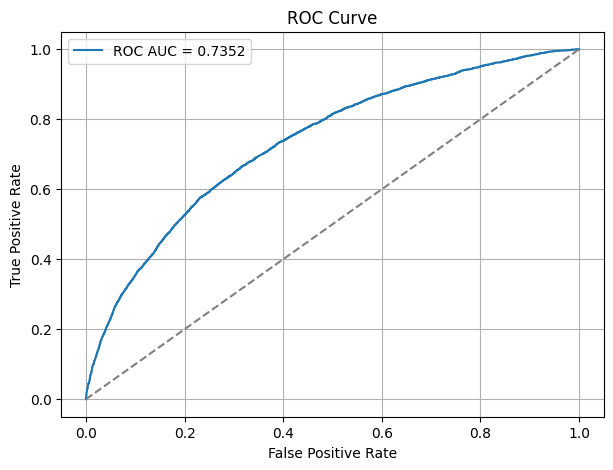

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_val:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

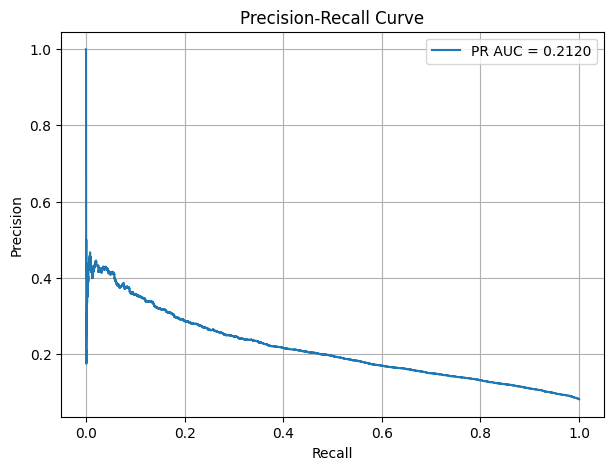

In [15]:
# Precision-Recall кривая
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

## TabNet

In [14]:
# Разделение
X_train_tab, X_test_tab, y_train_tab, y_test_tab = train_test_split(
    X_scaled.values, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
!pip install pytorch-tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [16]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [23]:
from pytorch_tabnet.callbacks import Callback
from tqdm.auto import tqdm

class TQDMProgressCallback(Callback):
    def __init__(self):
        self.epoch_bar = tqdm(total=25, desc="Training", position=0)

    def on_epoch_end(self, epoch_idx, logs=None):
        auc = logs.get('valid_auc')
        if auc is not None:
            self.epoch_bar.set_description(f"Epoch {epoch_idx+1} | AUC: {auc:.4f}")
        else:
            self.epoch_bar.set_description(f"Epoch {epoch_idx+1} | AUC: —")
        self.epoch_bar.update(1)

    def on_train_end(self, logs=None):
        self.epoch_bar.close()

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report

In [25]:
from tqdm import trange
import time


clf = TabNetClassifier(
    n_d=32, n_a=32,
    n_steps=5,
    gamma=1.5,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 10, "gamma": 0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',
    seed=42,
    verbose=0  # Отключим внутренний лог, чтобы не мешал tqdm
)

clf.fit(
    X_train=X_train_tab, y_train=y_train_tab,
    eval_set=[(X_test_tab, y_test_tab)],
    eval_name=['valid'],
    eval_metric=['balanced_accuracy'],
    max_epochs=25,
    patience=15,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    callbacks=[TQDMProgressCallback()],
)

Training:   0%|          | 0/25 [00:00<?, ?it/s]

Stop training because you reached max_epochs = 25 with best_epoch = 17 and best_valid_balanced_accuracy = 0.50799


In [26]:
# Предсказания
y_scores_tab = clf.predict_proba(X_test_tab)[:, 1]
threshold = 0.2  # или 0.15, чтобы модель чаще выбирала класс 1
y_pred_tab = (y_scores_tab >= threshold).astype(int)

# Метрики
roc_auc = roc_auc_score(y_test_tab, y_scores_tab)
print(f"ROC AUC: {roc_auc:.4f}")
print(classification_report(y_test_tab, y_pred_tab))

ROC AUC: 0.7404
              precision    recall  f1-score   support

           0       0.94      0.93      0.93     56538
           1       0.26      0.30      0.28      4965

    accuracy                           0.88     61503
   macro avg       0.60      0.61      0.61     61503
weighted avg       0.88      0.88      0.88     61503



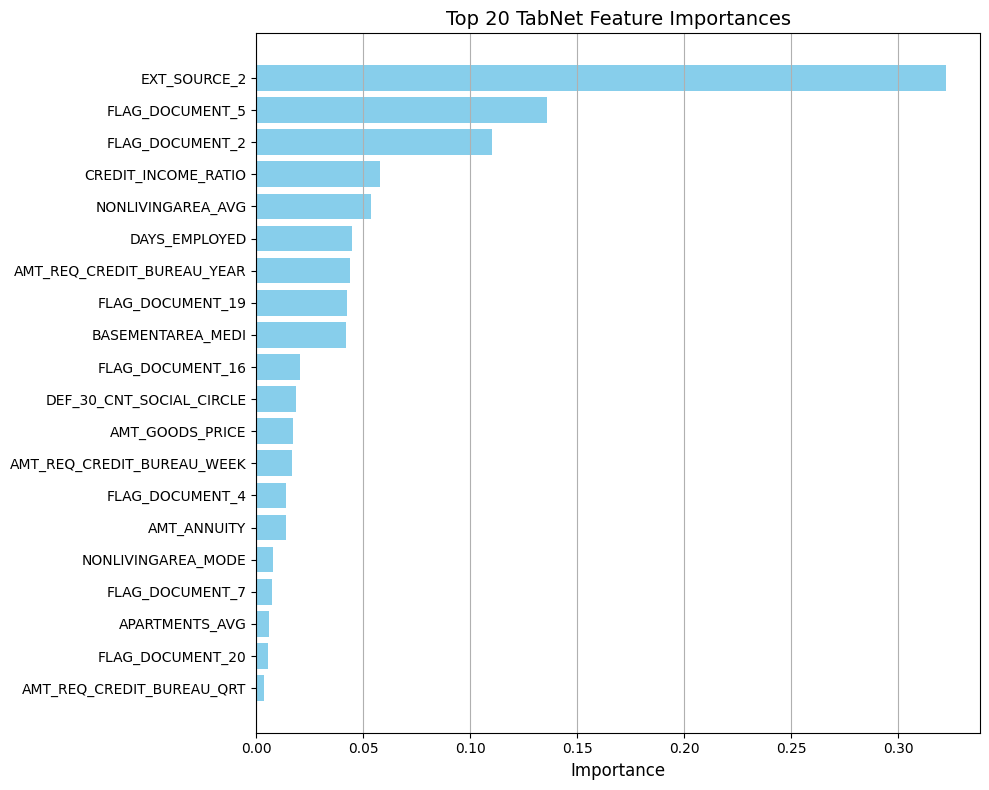

In [27]:
feature_importances = clf.feature_importances_
feature_names = X_scaled.columns

# В DataFrame для удобства
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Сортировка по убыванию
feat_df = feat_df.sort_values('Importance', ascending=False)

# Оставим только топ-20
top_n = 20
top_features = feat_df.head(top_n)

# Построим график
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'][::-1], top_features['Importance'][::-1], color='skyblue')
plt.title("Top 20 TabNet Feature Importances", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.grid(axis='x')
plt.tight_layout()
plt.show()